<a href="https://colab.research.google.com/github/pdoren/Machine-Learning-G105/blob/main/Desaf%C3%ADo_Detecci%C3%B3n_temprana_de_renuncias_en_empresa_de_telecomunicaciones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Desafío - Detección temprana de renuncias en empresa de telecomunicaciones

**Nombre**: Pablo Saavedra <br />
**Curso**: Modelos avanzados y Redes Neuronales (G105)


---

### Importación de librerías

In [57]:
from __future__ import annotations

# --- Standard library ---
from typing import Any, Dict, Iterable, Optional

# --- Third-party ---
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV

# importar DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier

# importar accuracy_score
from sklearn.metrics import accuracy_score

# importar classification_report
from sklearn.metrics import classification_report

# importar SMOTE
from imblearn.over_sampling import SMOTE

# Importar BaggingClassifier
from sklearn.ensemble import BaggingClassifier

# Importar RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

# Importar SVC
from sklearn.svm import SVC

# Importar Regresor Logístico
from sklearn.linear_model import LogisticRegression


# --- Pandas display options ---
pd.options.display.float_format = "{:,.2f}".format


### Funciones útiles

In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils.multiclass import type_of_target
from sklearn.metrics import balanced_accuracy_score, precision_recall_fscore_support, matthews_corrcoef
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay


def plot_hist(_df: pd.DataFrame, _num_cols: list, _n_cols: int = 3, _bins='auto'):
  total = len(_num_cols)
  n_rows = int(np.ceil(total / _n_cols))

  fig, axes = plt.subplots(n_rows, _n_cols, figsize=(5*_n_cols, 4*n_rows))
  axes = axes.flatten()  # Para iterar fácil

  for i, col in enumerate(_num_cols):
      sns.histplot(data=_df[col], kde=False, stat='density', ax=axes[i], bins=_bins)
      sns.kdeplot(data=_df[col], color='tomato', lw=3, ax=axes[i])
      axes[i].set_title(f"Distribución de {col}")

  # Eliminar ejes vacíos si sobran
  for j in range(i+1, len(axes)):
      fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()

def plot_outliers(_df: pd.DataFrame, _num_cols: list, _n_cols: int = 3):
  total = len(_num_cols)
  n_rows = int(np.ceil(total / _n_cols))

  fig, axes = plt.subplots(n_rows, _n_cols, figsize=(5*_n_cols, 4*n_rows))

  if isinstance(axes, np.ndarray):
      axes = axes.ravel()
  else:
      axes = np.array([axes])

  for i, col in enumerate(_num_cols):
      sns.boxplot(x=_df[col], flierprops = {'markerfacecolor':'tomato', 'marker':'D'}, ax=axes[i])
      axes[i].set_title(f"Outliers en {col}")
      axes[i].set_xlabel(col)

  # Eliminar ejes vacíos si sobran
  for j in range(i+1, len(axes)):
      fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()


def clean_outliers(_df: pd.DataFrame, _cols: list, _k: float=1.5):
  df_ret = _df.copy()
  for col in _cols:
    while True:
      q1, q3 = df_ret[col].quantile([.25, .75])
      iqr = q3 - q1
      low, high = q1 - _k * iqr, q3 + _k * iqr
      mask_out = (df_ret[col] < low) | (df_ret[col] > high)
      if mask_out.any():
        df_ret = df_ret[~mask_out]
      else:
        break
  return df_ret

def clean_outliers_percentiles(
    _df: pd.DataFrame,
    _cols: list,
    p_low: float = 1,     # percentil inferior
    p_high: float = 99    # percentil superior
):

    df_ret = _df.copy()

    for col in _cols:
        # Calcular umbrales por percentiles
        low = df_ret[col].quantile(p_low / 100)
        high = df_ret[col].quantile(p_high / 100)

        # Crear máscara de puntos válidos
        mask = (df_ret[col] >= low) & (df_ret[col] <= high)

        # Filtrar el DataFrame
        df_ret = df_ret[mask]

    return df_ret

def plot_count(_df: pd.DataFrame, _num_cols: list, _n_cols: int = 3, _X:str=None):
  total = len(_num_cols)
  n_rows = int(np.ceil(total / _n_cols))

  fig, axes = plt.subplots(n_rows, _n_cols, figsize=(5*_n_cols, 4*n_rows))
  axes = axes.flatten()  # Para iterar fácil

  if _X is not None:
    for i, col in enumerate(_num_cols):
        sns.countplot(x=_X, data=_df, ax=axes[i], hue=str(col))
        axes[i].set_title(f"Frecuencia de {col}")
  else:
    for i, col in enumerate(_num_cols):
        sns.countplot(y=col, data=_df, order=_df[col].value_counts().index, ax=axes[i], hue=str(col))
        axes[i].set_title(f"Frecuencia de {col}")

  # Eliminar ejes vacíos si sobran
  for j in range(i+1, len(axes)):
      fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()


def eval_model(
  model,
  X_train, y_train,
  X_test,  y_test,
  class_names: Optional[Iterable[str]] = None,
  *,
  normalize_cm: str | None = "true",   # "true" | "pred" | "all" | None
  average: str = "weighted",           # "macro" | "weighted" | "micro"
  plot: bool = True,
  title_prefix: str = "",
  binary_threshold: Optional[float] = None,  # si None y hay proba, usa 0.5
  zero_division: int = 0,
  label_map: Optional[Dict[Any, int]] = None # parche: {'No':0,'Yes':1}, etc.
) -> Dict[str, Any]:
  """
  Evalúa un clasificador en train/test con métricas y (opcional) gráficos.
  Incluye parche para alinear tipos de etiqueta (p. ej., y_true en str y y_pred en int).
  Retorna un diccionario con métricas.

  Parámetros clave:
  - class_names: etiquetas para los ejes de las matrices de confusión.
  - label_map: mapeo explícito de etiquetas reales -> enteros del modelo.
  - binary_threshold: umbral de decisión si el modelo expone predict_proba/decision_function.
  """
  # ---------------------------
  # 0) Parche de etiquetas
  # ---------------------------
  y_train = np.asarray(y_train)
  y_test  = np.asarray(y_test)

  # ¿El modelo genera probabilidades / scores?
  has_proba    = hasattr(model, "predict_proba")
  has_decision = hasattr(model, "decision_function")

  # Predicciones "crudas"
  y_pred_train = model.predict(X_train)
  y_pred_test  = model.predict(X_test)

  # Detecta tipo de problema (binario/multiclase)
  target_kind = type_of_target(y_test)
  is_binary = target_kind == "binary"

  # Si viene un mapeo explícito, aplícalo a y_* reales
  if label_map is not None:
      y_train = np.vectorize(label_map.get)(y_train)
      y_test  = np.vectorize(label_map.get)(y_test)

  # Si aún hay choque de tipos (str vs int), intenta auto-mapeo seguro para binario
  def _needs_alignment(y_true, y_pred):
      return (np.asarray(y_true).dtype.kind in "OUS") and (np.asarray(y_pred).dtype.kind in "iu")

  if _needs_alignment(y_test, y_pred_test):
      if not is_binary:
          raise TypeError(
              "Las etiquetas verdaderas son strings y las predicciones enteros, y el problema no es binario. "
              "Pasa 'label_map' o entrena el modelo con etiquetas codificadas (LabelEncoder)."
          )
      # Caso binario: preferimos usar class_names si fue entregado con orden [neg, pos]
      if class_names is not None and len(list(class_names)) == 2:
          auto_map = {class_names[0]: 0, class_names[1]: 1}
          y_train = np.vectorize(auto_map.get)(y_train)
          y_test  = np.vectorize(auto_map.get)(y_test)
      else:
          # Intento de usar el orden natural de las clases observadas (no 100% seguro)
          uniq = list(np.unique(y_train))
          if len(uniq) == 2 and set(np.unique(y_pred_test)) <= {0, 1}:
              auto_map = {uniq[0]: 0, uniq[1]: 1}
              y_train = np.vectorize(auto_map.get)(y_train)
              y_test  = np.vectorize(auto_map.get)(y_test)
          else:
              raise TypeError(
                  "No se pudo alinear automáticamente y_true (strings) con y_pred (0/1). "
                  "Proporciona class_names=['No','Sí'] o label_map={'No':0,'Sí':1}."
              )

  # ---------------------------
  # 1) Umbral binario (si aplica)
  # ---------------------------
  proba_train = proba_test = None
  pos_scores_train = pos_scores_test = None

  if is_binary and (has_proba or has_decision):
      if has_proba:
          proba_train = model.predict_proba(X_train)
          proba_test  = model.predict_proba(X_test)
          pos_scores_train = proba_train[:, 1]
          pos_scores_test  = proba_test[:, 1]
      else:
          # decision_function
          pos_scores_train = model.decision_function(X_train)
          pos_scores_test  = model.decision_function(X_test)

      thr = 0.5 if binary_threshold is None else float(binary_threshold)
      y_pred_train = (pos_scores_train >= thr).astype(int)
      y_pred_test  = (pos_scores_test  >= thr).astype(int)

  # ---------------------------
  # 2) Métricas numéricas
  # ---------------------------
  metrics: Dict[str, Any] = {}

  def block_metrics(y_true, y_pred, split: str) -> Dict[str, float]:
      acc  = accuracy_score(y_true, y_pred)
      bacc = balanced_accuracy_score(y_true, y_pred)
      p, r, f1, _ = precision_recall_fscore_support(
          y_true, y_pred, average=average, zero_division=zero_division
      )
      mcc = matthews_corrcoef(y_true, y_pred)
      return {
          f"{split}_accuracy": acc,
          f"{split}_balanced_accuracy": bacc,
          f"{split}_precision_{average}": p,
          f"{split}_recall_{average}": r,
          f"{split}_f1_{average}": f1,
          f"{split}_mcc": mcc
      }

  metrics.update(block_metrics(y_train, y_pred_train, "train"))
  metrics.update(block_metrics(y_test,  y_pred_test,  "test"))

  # AUCs si tenemos scores
  if is_binary and (pos_scores_test is not None):
      try:
          metrics["train_roc_auc"] = roc_auc_score(y_train, pos_scores_train)
          metrics["test_roc_auc"]  = roc_auc_score(y_test,  pos_scores_test)
          metrics["train_pr_auc"]  = average_precision_score(y_train, pos_scores_train)
          metrics["test_pr_auc"]   = average_precision_score(y_test,  pos_scores_test)
      except Exception:
          pass

  # ---------------------------
  # 3) Reportes por clase (texto)
  # ---------------------------
  prefix = (title_prefix + " ") if title_prefix else ""
  print(prefix + "Reporte de clasificación (train):")
  print(classification_report(y_train, y_pred_train, digits=3, zero_division=zero_division))
  print(prefix + "Reporte de clasificación (test):")
  print(classification_report(y_test,  y_pred_test,  digits=3, zero_division=zero_division))

  # ---------------------------
  # 4) Gráficos
  # ---------------------------
  if plot:
      # Matrices de confusión
      fig, axes = plt.subplots(2, 2, figsize=(10, 8)) if is_binary and (pos_scores_test is not None) else plt.subplots(1, 2, figsize=(10, 4))
      axes = axes.flatten()

      ConfusionMatrixDisplay.from_predictions(
          y_true=y_train, y_pred=y_pred_train,
          display_labels=class_names, normalize=normalize_cm, ax=axes[0]
      )
      axes[0].set_title(f"{title_prefix} Confusión (train)")

      ConfusionMatrixDisplay.from_predictions(
          y_true=y_test, y_pred=y_pred_test,
          display_labels=class_names, normalize=normalize_cm, ax=axes[1]
      )
      axes[1].set_title(f"{title_prefix} Confusión (test)")

      # Curvas ROC y PR (binario con scores)
      if is_binary and (pos_scores_test is not None):
          RocCurveDisplay.from_predictions(y_test, pos_scores_test, ax=axes[2])
          axes[2].set_title(f"{title_prefix} ROC (test)")

          PrecisionRecallDisplay.from_predictions(y_test, pos_scores_test, ax=axes[3])
          axes[3].set_title(f"{title_prefix} Precision-Recall (test)")

      plt.tight_layout(); plt.show()

  return metrics


def plot_corr(
    df,
    method="pearson",
    figsize=(12, 10),
    annot=False,
    cmap="coolwarm",
    vmin=-1,
    vmax=1
):
    """
    Muestra un heatmap de la matriz de correlación de un DataFrame.

    Parámetros
    ----------
    df : pandas.DataFrame
        DataFrame de entrada
    method : str
        Método de correlación: 'pearson', 'spearman', 'kendall'
    figsize : tuple
        Tamaño de la figura
    annot : bool
        Mostrar valores numéricos en el heatmap
    cmap : str
        Colormap
    vmin, vmax : float
        Límites de la escala de correlación
    """

    # Seleccionar solo columnas numéricas
    df_num = df.select_dtypes(include="number")

    if df_num.shape[1] < 2:
        raise ValueError("Se requieren al menos dos columnas numéricas.")

    # Calcular correlación
    corr = df_num.corr(method=method)

    # Plot
    plt.figure(figsize=figsize)
    sns.heatmap(
        corr,
        annot=annot,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.8}
    )

    plt.title(f"Matriz de correlación ({method})", fontsize=14)
    plt.tight_layout()
    plt.show()

In [42]:
import pandas as pd
import numpy as np
from scipy.stats import mode


def bagging_het(X_train, y_train, T, estimators, X_test):
    """
    Crea un modelo Bagging usando estimadores heterogéneos.
    En que genera una cantidad T de muestras bootstrap y
    para cada una de ellas se entrena un estimador escogido
    en forma aleatoria desde la bolsa disponible.
    La estimación final usando los modelos entrenados se
    realiza por mayoría de votos.

    Basado en

    Parámetros:
    -----------
    X_train : DataFrame
        Conjunto de entrenamiento sin columna target.
    y_train : Series
        Datos con las clases asociadas a cada obs. de X_train
    T : int
        Representa la cantidad de muestras bootstrap a generar,
        equivalente a la cantidad de estimadores a entrenar.
    X_test : DataFrame
        Conjunto de test sobre el cual se somete el ensamble

    Retorna:
    --------
    list
        Lista con los estimadores entrenados

    np.array
        Array con cantidad de filas igual a la cantidad de
        observaciones de X_test y T columnas cada una con
        la clasificación predicha por el estimador asignado

    Series
        resultado por mayoría de votos para el conjunto de test

    list
        Lista con los índices no repetidos de las observaciones
        excluidad en cada muestra bootstrap
    """

    trained_model = []
    yhat_test = np.zeros((X_test.shape[0], T))
    idx_oob = []
    for t in np.arange(0, T):
        sa1 = X_train.sample(n=X_train.shape[0], replace=True)

        idx_oob = list(set(idx_oob + list(set(X_train.index)-set(sa1.index))))

        idx_estimator = np.random.randint(0, len(estimators))
        estimator = estimators[idx_estimator]
        #print(idx_estimator, end='; ')

        estimator.fit(sa1, y_train[sa1.index])
        trained_model.append(estimator)

        yhat_test[:,t] = estimator.predict(X_test)

    yhat_out = pd.Series(data=mode(yhat_test, axis=1)[0], name='yhat')

    return trained_model, yhat_test, yhat_out, idx_oob


def bagging_het_predict(X, estimators):
    yhat = np.zeros((X.shape[0], len(estimators)))

    for i, est in enumerate(estimators):
        yhat[:,i] = est.predict(X)

    return pd.Series(data=mode(yhat, axis=1)[0], name='yhat')

In [78]:
from typing import Optional, Iterable, Dict, Any
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils.multiclass import type_of_target
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_recall_fscore_support,
    matthews_corrcoef,
    roc_auc_score,
    average_precision_score,
    classification_report,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    PrecisionRecallDisplay,
)

def eval_model_preds(
    X_train, y_train,
    X_test,  y_test,
    y_pred_train,
    y_pred_test,
    class_names: Optional[Iterable[str]] = None,
    *,
    normalize_cm: str | None = "true",   # "true" | "pred" | "all" | None
    average: str = "weighted",           # "macro" | "weighted" | "micro"
    plot: bool = True,
    title_prefix: str = "",
    # scores para binario (p.ej. proba[:,1] o decision_function)
    pos_scores_train: Optional[np.ndarray] = None,
    pos_scores_test: Optional[np.ndarray] = None,
    binary_threshold: Optional[float] = None,  # si no None y hay scores, recalcula y_pred
    zero_division: int = 0,
    label_map: Optional[Dict[Any, int]] = None # parche: {'No':0,'Yes':1}, etc.
) -> Dict[str, Any]:
    """
    Evalúa un clasificador en train/test con métricas y (opcional) gráficos,
    recibiendo predicciones ya calculadas (sin pasar el modelo).

    - y_pred_train/y_pred_test: predicción final (clase).
    - pos_scores_* (opcional): scores de clase positiva para AUC/ROC/PR (binario).
    """

    # ---------------------------
    # 0) Preparación / tipos
    # ---------------------------
    y_train = np.asarray(y_train)
    y_test  = np.asarray(y_test)
    y_pred_train = np.asarray(y_pred_train)
    y_pred_test  = np.asarray(y_pred_test)

    target_kind = type_of_target(y_test)
    is_binary = target_kind == "binary"

    # Si viene un mapeo explícito, aplícalo a y_* reales
    if label_map is not None:
        y_train = np.vectorize(label_map.get)(y_train)
        y_test  = np.vectorize(label_map.get)(y_test)

    # Si hay choque de tipos (str vs int), intenta auto-mapeo seguro para binario
    def _needs_alignment(y_true, y_pred):
        return (np.asarray(y_true).dtype.kind in "OUS") and (np.asarray(y_pred).dtype.kind in "iu")

    if _needs_alignment(y_test, y_pred_test):
        if not is_binary:
            raise TypeError(
                "Las etiquetas verdaderas son strings y las predicciones enteros, y el problema no es binario. "
                "Pasa 'label_map' o codifica etiquetas (LabelEncoder)."
            )
        if class_names is not None and len(list(class_names)) == 2:
            auto_map = {list(class_names)[0]: 0, list(class_names)[1]: 1}
            y_train = np.vectorize(auto_map.get)(y_train)
            y_test  = np.vectorize(auto_map.get)(y_test)
        else:
            uniq = list(np.unique(y_train))
            if len(uniq) == 2 and set(np.unique(y_pred_test)) <= {0, 1}:
                auto_map = {uniq[0]: 0, uniq[1]: 1}
                y_train = np.vectorize(auto_map.get)(y_train)
                y_test  = np.vectorize(auto_map.get)(y_test)
            else:
                raise TypeError(
                    "No se pudo alinear automáticamente y_true (strings) con y_pred (0/1). "
                    "Proporciona class_names=['No','Sí'] o label_map={'No':0,'Sí':1}."
                )

    # ---------------------------
    # 1) Umbral binario (si aplica) usando scores
    # ---------------------------
    if is_binary and (pos_scores_train is not None or pos_scores_test is not None) and (binary_threshold is not None):
        thr = float(binary_threshold)
        if pos_scores_train is not None:
            y_pred_train = (np.asarray(pos_scores_train) >= thr).astype(int)
        if pos_scores_test is not None:
            y_pred_test  = (np.asarray(pos_scores_test)  >= thr).astype(int)

    # ---------------------------
    # 2) Métricas numéricas
    # ---------------------------
    metrics: Dict[str, Any] = {}

    def block_metrics(y_true, y_pred, split: str) -> Dict[str, float]:
        acc  = accuracy_score(y_true, y_pred)
        bacc = balanced_accuracy_score(y_true, y_pred)
        p, r, f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average=average, zero_division=zero_division
        )
        mcc = matthews_corrcoef(y_true, y_pred)
        return {
            f"{split}_accuracy": acc,
            f"{split}_balanced_accuracy": bacc,
            f"{split}_precision_{average}": p,
            f"{split}_recall_{average}": r,
            f"{split}_f1_{average}": f1,
            f"{split}_mcc": mcc
        }

    metrics.update(block_metrics(y_train, y_pred_train, "train"))
    metrics.update(block_metrics(y_test,  y_pred_test,  "test"))

    # AUCs si tenemos scores (binario)
    if is_binary and (pos_scores_test is not None):
        try:
            if pos_scores_train is not None:
                metrics["train_roc_auc"] = roc_auc_score(y_train, pos_scores_train)
                metrics["train_pr_auc"]  = average_precision_score(y_train, pos_scores_train)
            metrics["test_roc_auc"] = roc_auc_score(y_test, pos_scores_test)
            metrics["test_pr_auc"]  = average_precision_score(y_test, pos_scores_test)
        except Exception:
            pass

    # ---------------------------
    # 3) Reportes por clase
    # ---------------------------
    prefix = (title_prefix + " ") if title_prefix else ""
    print(prefix + "Reporte de clasificación (train):")
    print(classification_report(y_train, y_pred_train, digits=3, zero_division=zero_division))
    print(prefix + "Reporte de clasificación (test):")
    print(classification_report(y_test,  y_pred_test,  digits=3, zero_division=zero_division))

    # ---------------------------
    # 4) Gráficos
    # ---------------------------
    if plot:
        has_scores = is_binary and (pos_scores_test is not None)
        fig, axes = (plt.subplots(2, 2, figsize=(10, 8)) if has_scores
                     else plt.subplots(1, 2, figsize=(10, 4)))
        axes = np.array(axes).flatten()

        ConfusionMatrixDisplay.from_predictions(
            y_true=y_train, y_pred=y_pred_train,
            display_labels=class_names, normalize=normalize_cm, ax=axes[0]
        )
        axes[0].set_title(f"{title_prefix} Confusión (train)")

        ConfusionMatrixDisplay.from_predictions(
            y_true=y_test, y_pred=y_pred_test,
            display_labels=class_names, normalize=normalize_cm, ax=axes[1]
        )
        axes[1].set_title(f"{title_prefix} Confusión (test)")

        if has_scores:
            RocCurveDisplay.from_predictions(y_test, pos_scores_test, ax=axes[2])
            axes[2].set_title(f"{title_prefix} ROC (test)")

            PrecisionRecallDisplay.from_predictions(y_test, pos_scores_test, ax=axes[3])
            axes[3].set_title(f"{title_prefix} Precision-Recall (test)")

        plt.tight_layout()
        plt.show()

    return metrics


## 1. Análisis de los datos

Importa las librerías necesarias y la base de datos, y realiza un análisis por variable usando visualizaciones. Debes considerar las posibles correlaciones y representarlas en un heatmap.

---

### Carga de datos

In [3]:
# Carga de datos
df = pd.read_csv('/content/drive/MyDrive/telecom_churn.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Churn            3333 non-null   int64  
 1   AccountWeeks     3333 non-null   int64  
 2   ContractRenewal  3333 non-null   int64  
 3   DataPlan         3333 non-null   int64  
 4   DataUsage        3333 non-null   float64
 5   CustServCalls    3333 non-null   int64  
 6   DayMins          3333 non-null   float64
 7   DayCalls         3333 non-null   int64  
 8   MonthlyCharge    3333 non-null   float64
 9   OverageFee       3333 non-null   float64
 10  RoamMins         3333 non-null   float64
dtypes: float64(5), int64(6)
memory usage: 286.6 KB


In [5]:
df.head()

,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
0,0,128,1,1,2.70,1,265.10,110,89.00,9.87,10.00
1,0,107,1,1,3.70,1,161.60,123,82.00,9.78,13.70
2,0,137,1,0,0.00,0,243.40,114,52.00,6.06,12.20
3,0,84,0,0,0.00,2,299.40,71,57.00,3.10,6.60
4,0,75,0,0,0.00,3,166.70,113,41.00,7.42,10.10


In [6]:
# Cantidad de nulos
print("Cantidad de nulos", df.isnull().sum())

Cantidad de nulos Churn              0
AccountWeeks       0
ContractRenewal    0
DataPlan           0
DataUsage          0
CustServCalls      0
DayMins            0
DayCalls           0
MonthlyCharge      0
OverageFee         0
RoamMins           0
dtype: int64


In [7]:
# Cantidad de registros duplicados
print("Cantidad de duplicados: ", df.duplicated().sum())

Cantidad de duplicados:  0


In [8]:
df.describe()

,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
count,"3,333.00","3,333.00","3,333.00","3,333.00","3,333.00","3,333.00","3,333.00","3,333.00","3,333.00","3,333.00","3,333.00"
mean,0.14,101.06,0.90,0.28,0.82,1.56,179.78,100.44,56.31,10.05,10.24
std,0.35,39.82,0.30,0.45,1.27,1.32,54.47,20.07,16.43,2.54,2.79
min,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,14.00,0.00,0.00
25%,0.00,74.00,1.00,0.00,0.00,1.00,143.70,87.00,45.00,8.33,8.50
50%,0.00,101.00,1.00,0.00,0.00,1.00,179.40,101.00,53.50,10.07,10.30
75%,0.00,127.00,1.00,1.00,1.78,2.00,216.40,114.00,66.20,11.77,12.10
max,1.00,243.00,1.00,1.00,5.40,9.00,350.80,165.00,111.30,18.19,20.00


> **Reporte de los datos**:
> - Se tiene un total de 3.333 registros.
> - No existen valores nulos
> - No exiten registros duplicados
> - En la columna Churn existen más clientes que no abandonan (clases desbalanceadas)  

In [11]:
variables_cuantitativas = ["AccountWeeks", "DataUsage", "CustServCalls", "DayMins", "DayCalls", "MonthlyCharge", "OverageFee", "RoamMins"]
variables_cualitativas = ["Churn", "ContractRenewal", "DataPlan"]

> Distribución de los datos

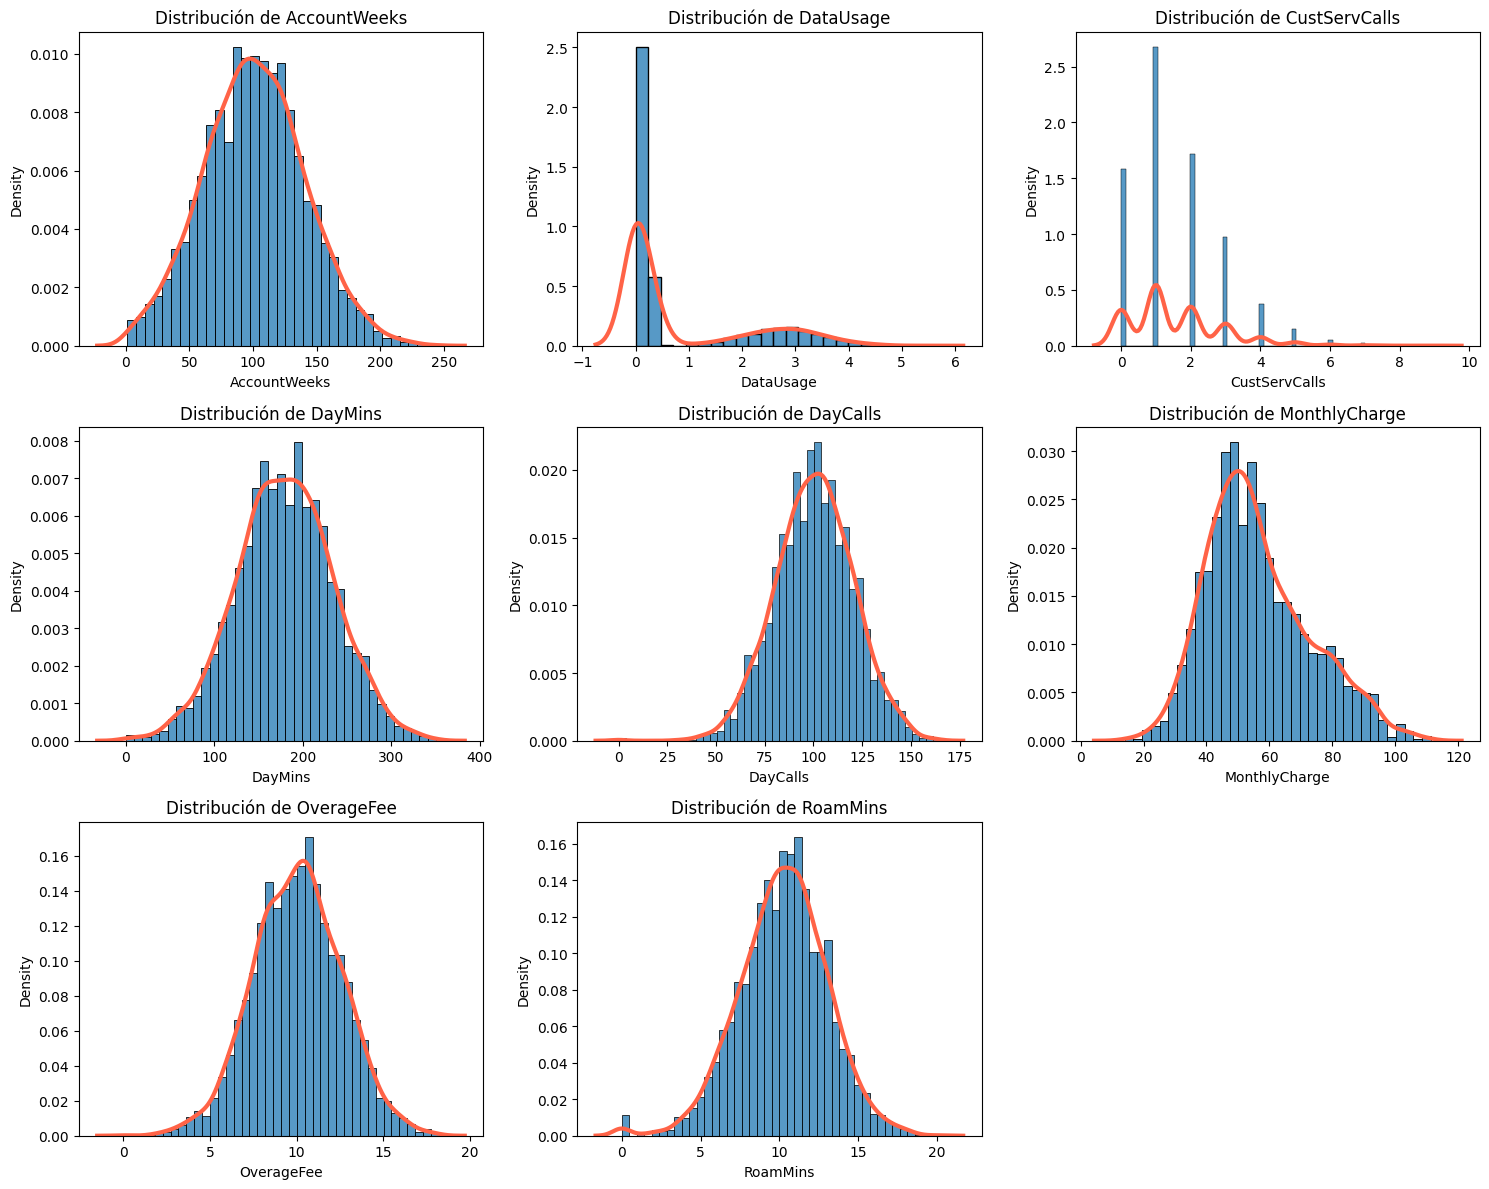

In [12]:
# Variables cuantitativas
plot_hist(df, variables_cuantitativas)

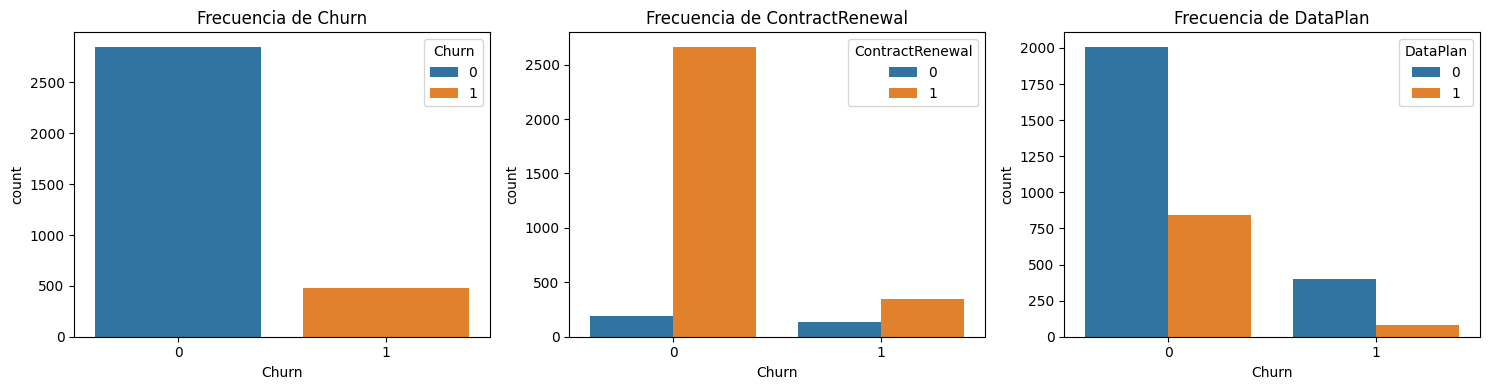

In [13]:
# Variables cualitativas
plot_count(df, variables_cualitativas, _X='Churn')

> La distribución de los datos indican:
> - Variables Cuantitativas:
>    - Casi todas las variables cuantitativas distribuyen de forma normal, excepto DataUsage y CustServCalls.
>    - DataUsage paraciera que tiene 2 medias (combinación de 2 normales).
>    - CustServCalls es discreta y con una moda en 1 llamada a atención del cliente.
> - Variables Cualitativas:
>    - **Churn**: están debalanceada las clases.
>    - **ContractRenewal**: tiene una gran cantidad de clientes que renovaron tanto en clientes que se mantienen como los que se van. Pero la diferencia es mucho más grande en los clientes que se mantienen. Esto último indica que la gran mayoria de los clientes actuales son antiguos porque renovaron sus contratos.   
>    - **DataPlan**: indica que la gran mayoria de loc clientes no tiene plan de datos.

### Correlaciones

> Se calcula la correlación Pearson debido a que las variables son normales

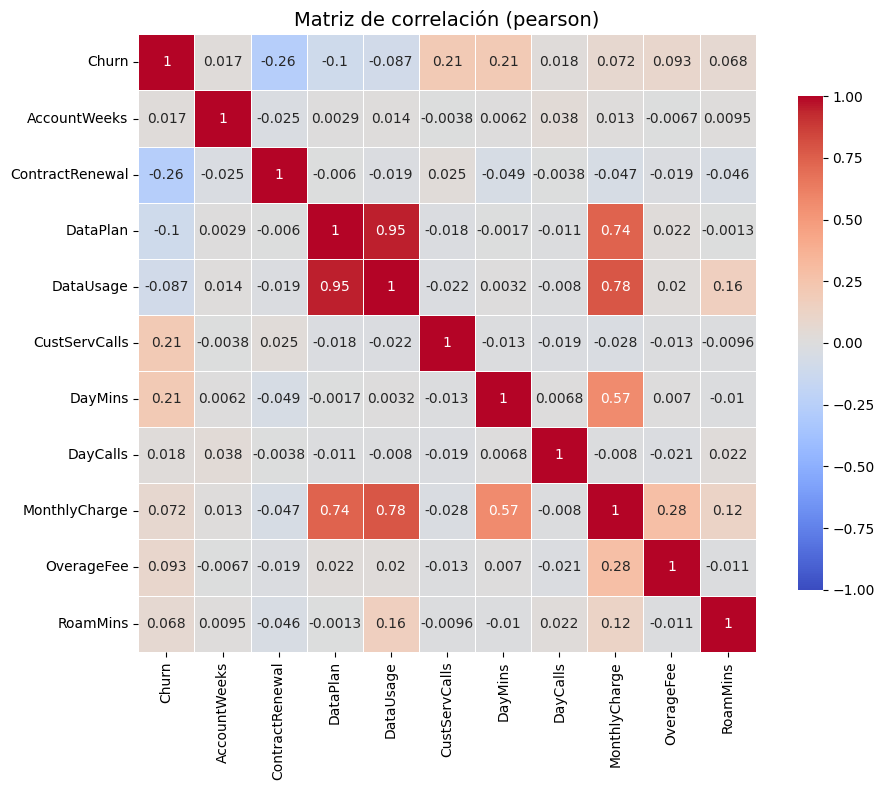

In [16]:
# Mostrar un gráfico con la matriz de correlación
plot_corr(df, method="pearson",
    figsize=(10, 8), annot=True)

> **Correlación**:
> - Las correlaciones son bajas respecto al Churn, la más grande es de 0.21 con CustServCalls y DayMins y -0.26 con ContractRenewal.
> - Existen correlaciones muy grandes entre DataPlan y DataUsage (0.95). Al mismo tiempo estas con MonthlyCharge (0.74 y 0.78).

## 2. Árbol de Decisión

Desarrolla un modelo de árbol de decisión sin modificar sus hiper parámetros y despliega sus métricas de desempeño. Luego, mejora este modelo de forma de evitar el overfitting usando búsqueda por grilla con 5 kfold:

- max_depth: [5, 10, 15, 20, 25]
- min_samples_split: [0.01, 0.02, 0.03, 0.04] Da a conocer los mejores hiper

parámetros encontrados y el desempeño del modelo, tanto en los datos de entrenamiento como en los de test.

---

In [17]:
# Separar data set en conjunto de entrenamiento y prueba
X = df.drop(columns=["Churn"])
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

> Árbol de decisión, parámetros por defecto

In [20]:
# arbol de decisión parámetros por defecto
arbol_default = DecisionTreeClassifier()
arbol_default.fit(X_train, y_train)

DecisionTreeClassifier()

Reporte de clasificación (train):
              precision    recall  f1-score   support

           0      1.000     1.000     1.000      2284
           1      1.000     1.000     1.000       382

    accuracy                          1.000      2666
   macro avg      1.000     1.000     1.000      2666
weighted avg      1.000     1.000     1.000      2666

Reporte de clasificación (test):
              precision    recall  f1-score   support

           0      0.927     0.926     0.927       566
           1      0.588     0.594     0.591       101

    accuracy                          0.876       667
   macro avg      0.758     0.760     0.759       667
weighted avg      0.876     0.876     0.876       667



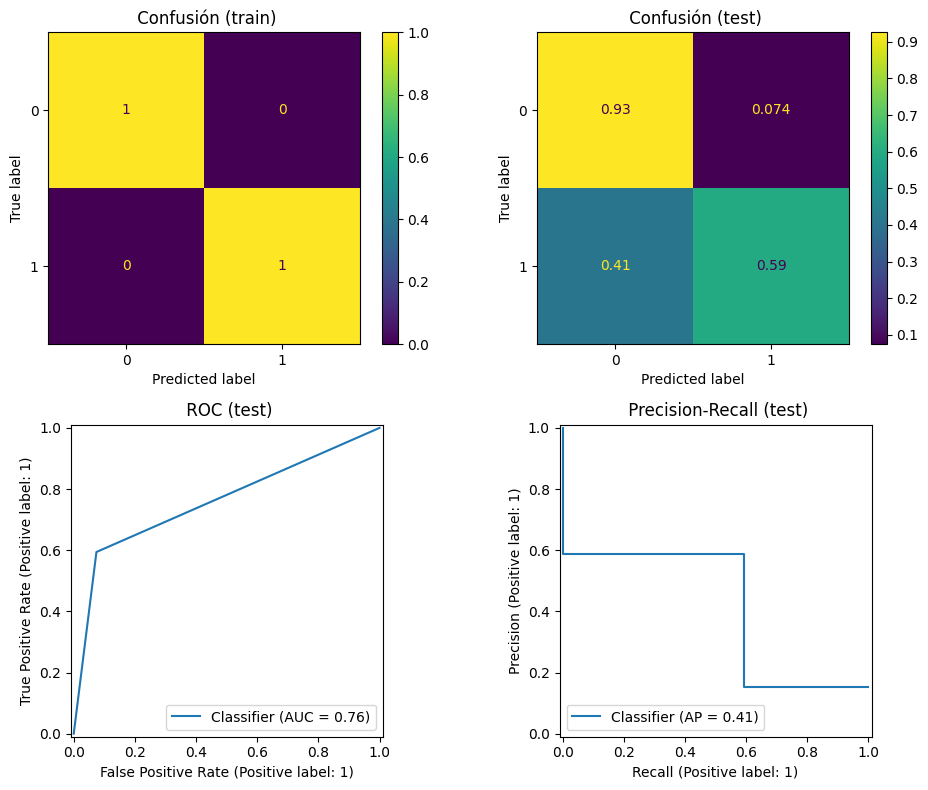

In [30]:
# Métricas de desempeño del arbol
arbol_default_metricas = eval_model(
    arbol_default, X_train, y_train, X_test, y_test)

In [31]:
arbol_default_metricas

{'train_accuracy': 1.0,
 'train_balanced_accuracy': np.float64(1.0),
 'train_precision_weighted': 1.0,
 'train_recall_weighted': 1.0,
 'train_f1_weighted': 1.0,
 'train_mcc': np.float64(1.0),
 'test_accuracy': 0.8755622188905547,
 'test_balanced_accuracy': np.float64(0.7599272294720638),
 'test_precision_weighted': 0.8760707621202413,
 'test_recall_weighted': 0.8755622188905547,
 'test_f1_weighted': 0.8758137036067035,
 'test_mcc': np.float64(0.5177574612377771),
 'train_roc_auc': np.float64(1.0),
 'test_roc_auc': np.float64(0.7599272294720638),
 'train_pr_auc': np.float64(1.0),
 'test_pr_auc': np.float64(0.4109159747441364)}

> Resultado de **Árbol de Decisión default** con conjunto de test:
> - **Accuracy**: 0.88
> - **MCC**: 0.52
> - **F1 Score**: 0.88

> Árbol de decisión, con parámetros

In [44]:
arbol = DecisionTreeClassifier()

param_grid_tree = {
    "max_depth": [5, 10, 15, 20, 25],
    "min_samples_split": [0.01, 0.02, 0.03, 0.04]
}

grid_arbol = GridSearchCV(
    estimator=arbol,
    param_grid=param_grid_tree,
    scoring="f1",
    cv=5,
    n_jobs=-1
)

grid_arbol.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20, 25],
                         'min_samples_split': [0.01, 0.02, 0.03, 0.04]},
             scoring='f1')

In [74]:
best_arbol = grid_arbol.best_estimator_
grid_arbol.best_params_, grid_arbol.best_score_

({'max_depth': 5, 'min_samples_split': 0.03}, np.float64(0.7099113724344097))

> Parámetros de Árbol de Decisión encontrados con busqueda por grilla:
>   - **max_depth**: 5
>   - **min_samples_split**: 0.03

Reporte de clasificación (train):
              precision    recall  f1-score   support

           0      0.938     0.992     0.964      2284
           1      0.928     0.605     0.732       382

    accuracy                          0.937      2666
   macro avg      0.933     0.798     0.848      2666
weighted avg      0.936     0.937     0.931      2666

Reporte de clasificación (test):
              precision    recall  f1-score   support

           0      0.918     0.984     0.950       566
           1      0.850     0.505     0.634       101

    accuracy                          0.912       667
   macro avg      0.884     0.745     0.792       667
weighted avg      0.907     0.912     0.902       667



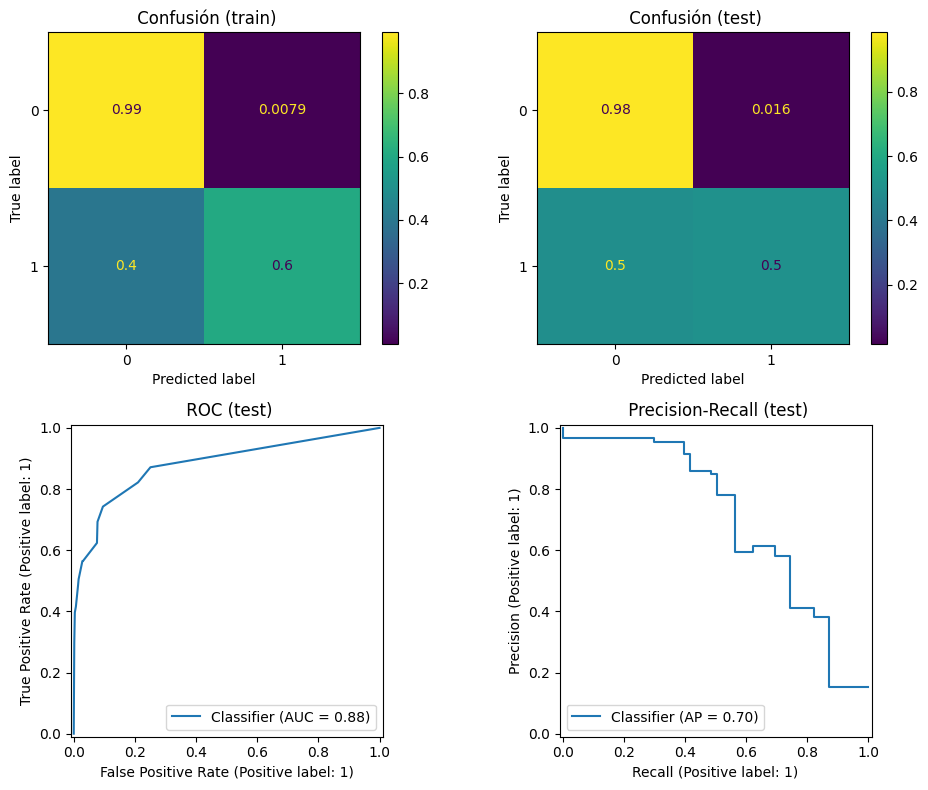

In [46]:
best_arbol_metrica = eval_model(
    best_arbol, X_train, y_train, X_test, y_test)

In [47]:
best_arbol_metrica

{'train_accuracy': 0.9366091522880721,
 'train_balanced_accuracy': np.float64(0.7984155656009022),
 'train_precision_weighted': 0.9361195059969514,
 'train_recall_weighted': 0.9366091522880721,
 'train_f1_weighted': 0.9308252226162075,
 'train_mcc': np.float64(0.7186099077648693),
 'test_accuracy': 0.9115442278860569,
 'test_balanced_accuracy': np.float64(0.7445247174894167),
 'test_precision_weighted': 0.9073872042561916,
 'test_recall_weighted': 0.9115442278860569,
 'test_f1_weighted': 0.9018271280873994,
 'test_mcc': np.float64(0.6127053792485514),
 'train_roc_auc': np.float64(0.901203798791502),
 'test_roc_auc': np.float64(0.8802435013819403),
 'train_pr_auc': np.float64(0.7751430843544652),
 'test_pr_auc': np.float64(0.7002433459274962)}

> Resultado de **Árbol de Decisión con parámetros** con conjunto de test:
> - **Accuracy**: 0.91
> - **MCC**: 0.61
> - **F1 Score**: 0.90
>
> Mejoró respecto al modelo anterior, mejor precisión y diferencias entre clases.

## 3. Bagging

Balancea las clases usando SMOTE para el conjunto de entrenamiento. Luego, aplica un modelo de Bagging con 200 estimadores y muestra las métricas sobre el conjunto de test.

---

In [51]:
# Balancear conjunto de entrenamiento X_train con SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [54]:
# Aplica un modelo de Bagging con 200 estimadores
bagging_model = BaggingClassifier(n_estimators=200, random_state=42)
bagging_model.fit(X_train_smote, y_train_smote)

BaggingClassifier(n_estimators=200, random_state=42)

Reporte de clasificación (train):
              precision    recall  f1-score   support

           0      1.000     1.000     1.000      2284
           1      1.000     1.000     1.000      2284

    accuracy                          1.000      4568
   macro avg      1.000     1.000     1.000      4568
weighted avg      1.000     1.000     1.000      4568

Reporte de clasificación (test):
              precision    recall  f1-score   support

           0      0.943     0.929     0.936       566
           1      0.633     0.683     0.657       101

    accuracy                          0.892       667
   macro avg      0.788     0.806     0.797       667
weighted avg      0.896     0.892     0.894       667



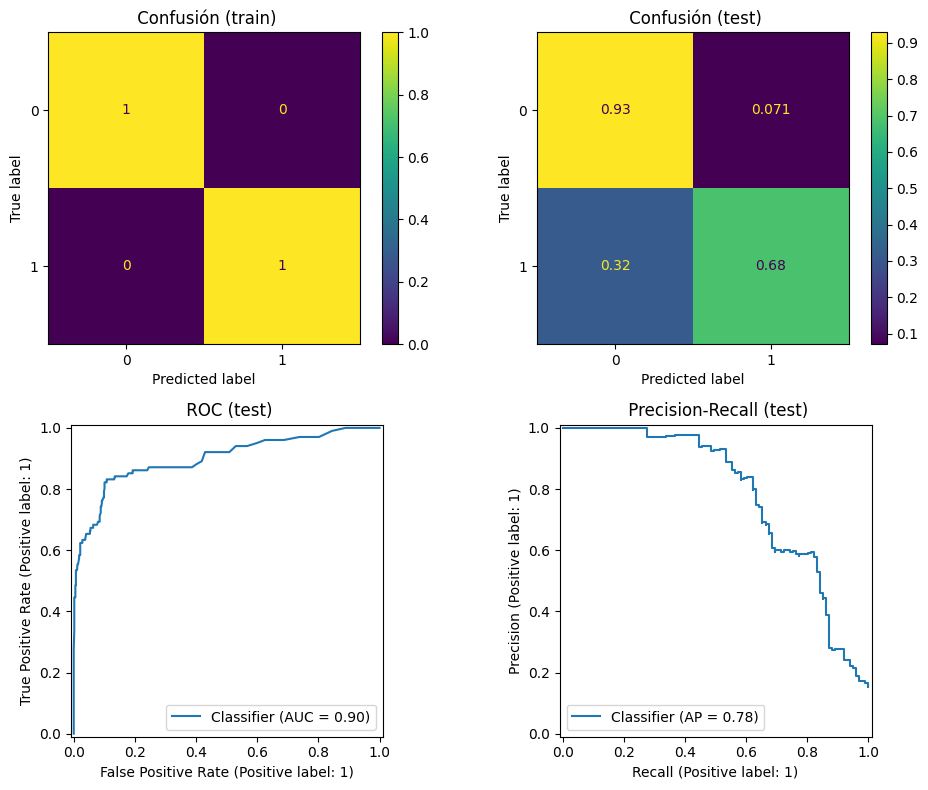

In [55]:
# Evaluar modelo Bagging
bagging_metricas = eval_model(
    bagging_model, X_train_smote, y_train_smote, X_test, y_test)

In [56]:
bagging_metricas

{'train_accuracy': 1.0,
 'train_balanced_accuracy': np.float64(1.0),
 'train_precision_weighted': 1.0,
 'train_recall_weighted': 1.0,
 'train_f1_weighted': 1.0,
 'train_mcc': np.float64(1.0),
 'test_accuracy': 0.8920539730134932,
 'test_balanced_accuracy': np.float64(0.8062484693699052),
 'test_precision_weighted': 0.8957676138748226,
 'test_recall_weighted': 0.8920539730134932,
 'test_f1_weighted': 0.8937259382510069,
 'test_mcc': np.float64(0.5938031218035792),
 'train_roc_auc': np.float64(1.0),
 'test_roc_auc': np.float64(0.8990833712346499),
 'train_pr_auc': np.float64(1.0),
 'test_pr_auc': np.float64(0.7794471141785946)}

> Resultado de **Bagging** (entrenado con dataset resampleado con SMOTE) con conjunto de test:
> - **Accuracy**: 0.89
> - **MCC**: 0.59
> - **F1 Score**: 0.89
>
> Bajo un poco respecto al Árbol de Decisión anterior.

## 4. Bagging heterogeneo

Implementa un modelo de Bagging usando modelos heterogéneos con los siguientes estimadores: Regresión Logística, Árbol de decisión, y dos SVM de clasificación con kernel ‘rbf’ y ‘sigmoid’. Para ello considera 200 muestras bootstrap (T).

Debes calibrar la importancia de los modelos, repitiendo el modelo que sea más importante en la lista de modelos a entrenar. Considera que un mejor modelo es aquel con mejor f1-score. Muestra las métricas del modelo final aplicado al conjunto de test. (Para realizar esta tarea utiliza la función bagging_het que se encuentra en el archivo util_bagging.py)

---

In [71]:
# Estimadores
logreg = LogisticRegression(max_iter=1000)
arbolex = DecisionTreeClassifier()
svm_rbf = SVC(kernel="rbf", random_state=42)
svm_sig = SVC(kernel="sigmoid", random_state=42)

estimators = [logreg, arbolex, svm_rbf, svm_sig]

In [73]:
%%time
bagging_het_models, yhat_test, yhat_out, idx_oob = bagging_het(
    X_train_smote, y_train_smote, 200, estimators, X_test);

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

CPU times: user 2min 56s, sys: 4.48 s, total: 3min 1s
Wall time: 3min 13s


Reporte de clasificación (train):
              precision    recall  f1-score   support

           0      0.861     0.922     0.890      2284
           1      0.916     0.851     0.882      2284

    accuracy                          0.887      4568
   macro avg      0.889     0.887     0.886      4568
weighted avg      0.889     0.887     0.886      4568

Reporte de clasificación (test):
              precision    recall  f1-score   support

           0      0.941     0.876     0.908       566
           1      0.500     0.693     0.581       101

    accuracy                          0.849       667
   macro avg      0.721     0.785     0.744       667
weighted avg      0.874     0.849     0.858       667



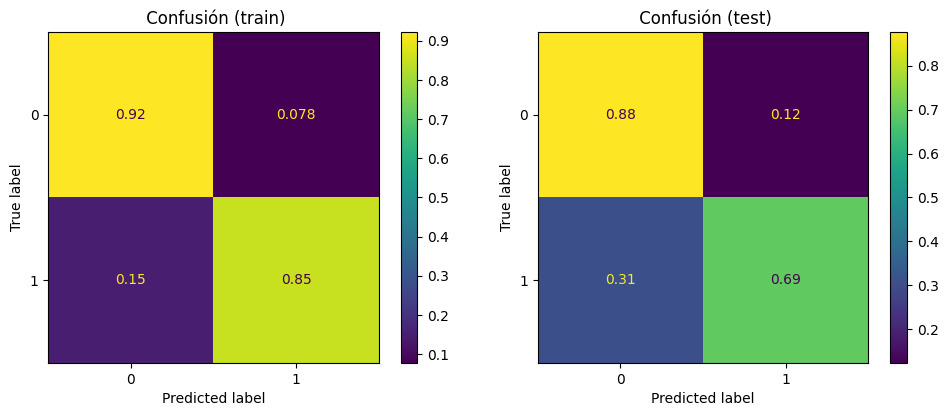

In [79]:
y_pred_tr = bagging_het_predict(X_train_smote, bagging_het_models)
y_pred_te = bagging_het_predict(X_test, bagging_het_models)

bag_het_metricas = eval_model_preds(
    X_train_smote, y_train_smote, X_test, y_test,
    y_pred_tr, y_pred_te,
    plot=True
)

In [80]:
bag_het_metricas

{'train_accuracy': 0.8866024518388792,
 'train_balanced_accuracy': np.float64(0.8866024518388791),
 'train_precision_weighted': 0.8885572089460336,
 'train_recall_weighted': 0.8866024518388792,
 'train_f1_weighted': 0.8864596518873457,
 'train_mcc': np.float64(0.7751571960788554),
 'test_accuracy': 0.848575712143928,
 'test_balanced_accuracy': np.float64(0.7846971976349578),
 'test_precision_weighted': 0.8743716377105566,
 'test_recall_weighted': 0.848575712143928,
 'test_f1_weighted': 0.8581263536021735,
 'test_mcc': np.float64(0.5012019649581434)}

> Resultado de **Bagging Heterogeneo** (entrenado con dataset resampleado con SMOTE) con conjunto de test:
> - **Accuracy**: 0.85
> - **MCC**: 0.50
> - **F1 Score**: 0.86
>
> Bajo un poco respecto al Bagging anterior.

## 5. Ramdon Forest

Implementa un modelo de ensamble Random Forest usando como hiper parámetro n_estimators = 45. El modelo debe usar muestra OOB para estimar su ajuste ACCURACY, y debe mostrar las cuatro características más importantes junto con las métricas de desempeño en el conjunto de test.

---

In [85]:
# Implementa un modelo de ensamble Random Forest usando como hiper parámetro n_estimators = 45
n_estimators = 45
rf = RandomForestClassifier(n_estimators=n_estimators, oob_score=True, random_state=42, n_jobs=-1)
rf.fit(X_train_smote, y_train_smote)

RandomForestClassifier(n_estimators=45, n_jobs=-1, oob_score=True,
                       random_state=42)

In [86]:
oob_acc = getattr(rf, "oob_score_", None)

# --- Evaluación en test ---
y_pred_test = rf.predict(X_test)
test_acc = accuracy_score(y_test, y_pred_test)

importances = rf.feature_importances_
top_idx = np.argsort(importances)[::-1][:10]

feat_names = np.array(X_train.columns)

top_features = pd.DataFrame({
    "feature": feat_names[top_idx],
    "importance": importances[top_idx]
}).reset_index(drop=True)

# --- Prints requeridos ---
print(f"RandomForest (n_estimators={n_estimators})")
print(f"OOB Accuracy (estimación ajuste): {oob_acc:.4f}" if oob_acc is not None else "OOB Accuracy: N/A")
print(f"Test Accuracy: {test_acc:.4f}\n")

print("Top 4 características más importantes:")
display(top_features)  # si estás en notebook
# si no estás en notebook, usa: print(top_features.to_string(index=False))

RandomForest (n_estimators=45)
OOB Accuracy (estimación ajuste): 0.9328
Test Accuracy: 0.8981

Top 4 características más importantes:


,feature,importance
0,ContractRenewal,0.19
1,MonthlyCharge,0.17
2,DayMins,0.14
3,CustServCalls,0.13
4,DataUsage,0.08
5,OverageFee,0.07
6,AccountWeeks,0.06
7,RoamMins,0.06
8,DayCalls,0.06
9,DataPlan,0.04


> Está importancia de características tiene relación con los valores de correlación con Churn

Reporte de clasificación (train):
              precision    recall  f1-score   support

           0      1.000     1.000     1.000      2284
           1      1.000     1.000     1.000      2284

    accuracy                          1.000      4568
   macro avg      1.000     1.000     1.000      4568
weighted avg      1.000     1.000     1.000      4568

Reporte de clasificación (test):
              precision    recall  f1-score   support

           0      0.956     0.922     0.939       566
           1      0.636     0.762     0.694       101

    accuracy                          0.898       667
   macro avg      0.796     0.842     0.816       667
weighted avg      0.908     0.898     0.902       667



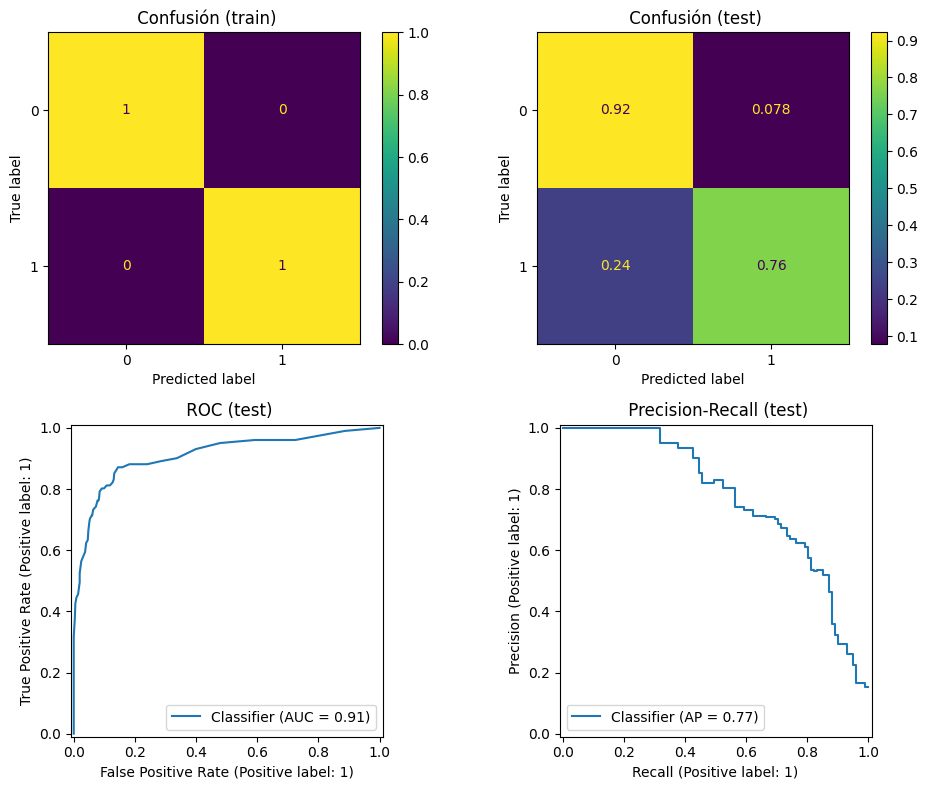

In [87]:
rf_metricas = eval_model(
    rf, X_train_smote, y_train_smote, X_test, y_test)

In [88]:
rf_metricas

{'train_accuracy': 1.0,
 'train_balanced_accuracy': np.float64(1.0),
 'train_precision_weighted': 1.0,
 'train_recall_weighted': 1.0,
 'train_f1_weighted': 1.0,
 'train_mcc': np.float64(1.0),
 'test_accuracy': 0.8980509745127436,
 'test_balanced_accuracy': np.float64(0.8423188608613512),
 'test_precision_weighted': 0.9076365912947623,
 'test_recall_weighted': 0.8980509745127436,
 'test_f1_weighted': 0.9017264651749568,
 'test_mcc': np.float64(0.6368552303288129),
 'train_roc_auc': np.float64(1.0),
 'test_roc_auc': np.float64(0.9097015708638002),
 'train_pr_auc': np.float64(1.0),
 'test_pr_auc': np.float64(0.769254861019551)}

> Resultado de **Random Forest** (entrenado con dataset resampleado con SMOTE) con conjunto de test:
> - **Accuracy**: 0.90
> - **MCC**: 0.64
> - **F1 Score**: 0.90
>
> Mejoró respecto a todos los modelos anteriores.

## 6. Random Forest con parámetros

Realiza una búsqueda de grilla para un modelo Random Forest para los siguientes rangos de valores para sus hiper parámetros:

- **n_estimators**: 50- 200 con paso de 10 completando 15 valores
- **max_features**: [‘sqrt’, ‘log2’, None]

Muestra los mejores hiper parámetros encontrados, la estimación de desempeño en los datos OOB, y despliega los cuatro atributos más importantes. ¿Tienen sentido estos? Analiza además las métricas de desempeño, ROC y AUC.

In [93]:
%%time
rf2 = RandomForestClassifier(oob_score=True, random_state=42, n_jobs=-1)

param_grid_rf = {
    "n_estimators": list(range(50, 50 + 10 * 15, 10)),
    "max_features": ['sqrt', 'log2', None]
}

grid_rf = GridSearchCV(
    estimator=rf2,
    param_grid=param_grid_rf,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(X_train_smote, y_train_smote);

Fitting 5 folds for each of 45 candidates, totalling 225 fits
CPU times: user 4.32 s, sys: 319 ms, total: 4.64 s
Wall time: 6min 49s


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_jobs=-1, oob_score=True,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_features': ['sqrt', 'log2', None],
                         'n_estimators': [50, 60, 70, 80, 90, 100, 110, 120,
                                          130, 140, 150, 160, 170, 180, 190]},
             scoring='f1', verbose=1)

In [94]:
best_rf = grid_rf.best_estimator_
grid_rf.best_params_, grid_rf.best_score_


({'max_features': 'sqrt', 'n_estimators': 160}, np.float64(0.9314021306024463))

> Parámetros de Random Forest encontrados con busqueda por grilla:
>   - **max_features**: sqrt
>   - **n_estimators**: 160

Reporte de clasificación (train):
              precision    recall  f1-score   support

           0      1.000     1.000     1.000      2284
           1      1.000     1.000     1.000      2284

    accuracy                          1.000      4568
   macro avg      1.000     1.000     1.000      4568
weighted avg      1.000     1.000     1.000      4568

Reporte de clasificación (test):
              precision    recall  f1-score   support

           0      0.951     0.922     0.936       566
           1      0.627     0.733     0.676       101

    accuracy                          0.894       667
   macro avg      0.789     0.827     0.806       667
weighted avg      0.902     0.894     0.897       667



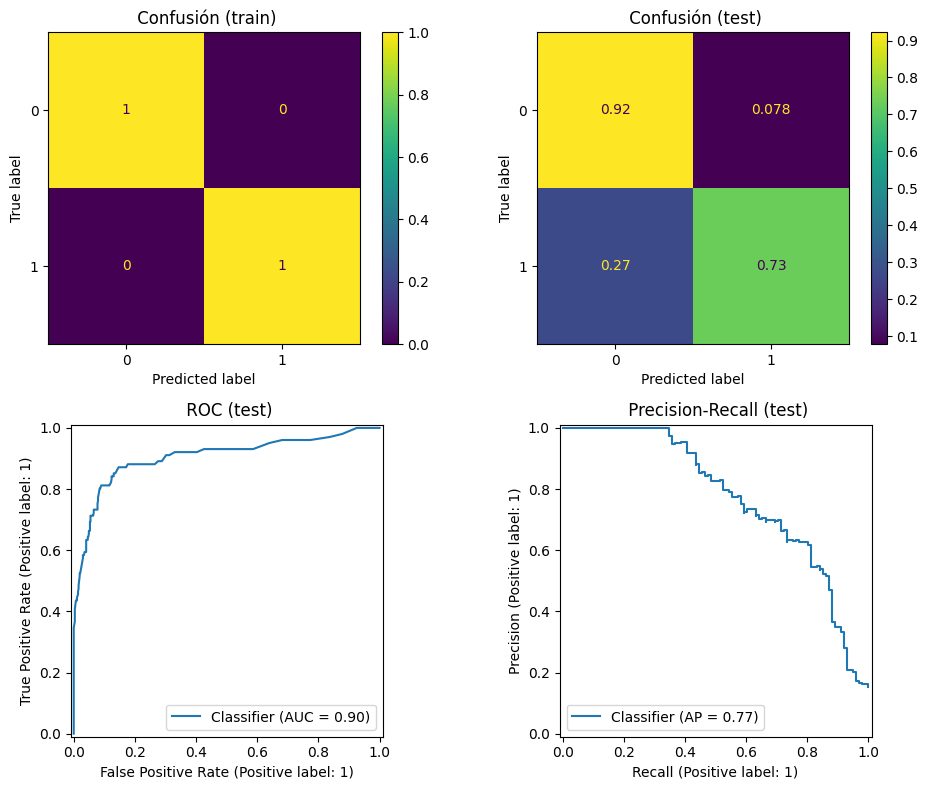

In [95]:
best_rf_metricas = eval_model(
    best_rf, X_train_smote, y_train_smote, X_test, y_test)

> Respecto a AUC y ROC:
> - El AUC = 0.90 confirma que el Random Forest separa muy bien las clases.
> - Inicialmente la curva ROC sube muy rapidamente, es decir, clasifica bien sin tantos falsos positivos.
> - Distingue bien entre clases.

In [114]:
best_rf_metricas

{'train_accuracy': 1.0,
 'train_balanced_accuracy': np.float64(1.0),
 'train_precision_weighted': 1.0,
 'train_recall_weighted': 1.0,
 'train_f1_weighted': 1.0,
 'train_mcc': np.float64(1.0),
 'test_accuracy': 0.8935532233883059,
 'test_balanced_accuracy': np.float64(0.8274673757128364),
 'test_precision_weighted': 0.9018034744783763,
 'test_recall_weighted': 0.8935532233883059,
 'test_f1_weighted': 0.8968732416149565,
 'test_mcc': np.float64(0.6152331976243863),
 'train_roc_auc': np.float64(1.0),
 'test_roc_auc': np.float64(0.9047160899835567),
 'train_pr_auc': np.float64(1.0),
 'test_pr_auc': np.float64(0.7729919127902805)}

> Resultado de **Random Forest entrenado con grilla** (entrenado con dataset resampleado con SMOTE) con conjunto de test:
> - **Accuracy**: 0.89
> - **MCC**: 0.62
> - **F1 Score**: 0.90
>
> Bajo muy poco respecto al modelo Random Forest anterior.

## 7. Clientes que podrían renunciar

Usando el modelo Random Forest con sus hiper parámetros ajustados, muestre los 15 clientes que presentan la mayor propensión a renunciar.

---

> Aplicado a todo el dataset

In [104]:
y_pred = best_rf.predict_proba(X)

In [105]:
df2 = df.copy()
df2['Churn_prob'] = y_pred[:, 1]

In [110]:
# Ordenar df2 por Churn_prob
df2 = df2.sort_values(by='Churn_prob', ascending=False)

# Obtener la lista de los primeros 15 registros
df2.head(15)

,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins,Churn_prob
2827,1,89,1,0,0.00,5,129.20,71,41.00,10.71,10.30,1.00
521,1,88,1,0,0.00,4,73.30,86,27.00,8.07,8.20,1.00
3272,1,133,1,0,0.00,2,295.00,141,70.00,11.18,12.90,1.00
365,1,154,1,0,0.00,1,350.80,75,79.00,10.83,10.10,1.00
1691,1,95,1,0,0.00,2,269.00,120,66.00,11.69,7.30,1.00
2958,1,95,1,0,0.00,6,128.60,115,41.00,10.81,6.30,1.00
2942,1,117,0,0,0.00,1,287.40,118,71.00,12.98,10.00,1.00
3035,1,88,1,0,0.00,4,85.70,112,34.00,11.08,11.60,1.00
1302,1,171,1,0,0.00,1,270.50,69,66.00,11.50,9.60,1.00
2267,1,29,1,0,0.00,2,313.20,103,72.00,10.82,12.80,1.00


> Aplicado solo al conjunto de test

In [112]:
y_pred = best_rf.predict_proba(X_test)

In [113]:
df3 = X_test.copy()
df3['Churn'] = y_test.copy()
df3['Churn_prob'] = y_pred[:, 1]

# Ordenar df3 por Churn_prob
df3 = df3.sort_values(by='Churn_prob', ascending=False)

# Obtener la lista de los primeros 15 registros
df3.head(15)

,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins,Churn,Churn_prob
3127,100,1,0,0.00,4,113.30,96,37.00,9.90,11.70,1,1.00
605,112,1,0,0.00,2,335.50,77,76.00,10.63,12.70,1,1.00
2536,119,1,0,0.00,0,294.20,100,70.00,11.63,9.00,1,1.00
1878,39,1,0,0.00,1,295.40,126,70.00,11.61,11.50,1,1.00
1078,80,1,0,0.00,0,322.30,113,74.00,11.10,6.70,1,1.00
3272,133,1,0,0.00,2,295.00,141,70.00,11.18,12.90,1,1.00
331,54,1,0,0.00,1,272.60,83,68.00,12.44,9.50,1,0.99
859,93,1,0,0.00,3,267.90,114,65.00,11.15,11.30,1,0.99
2325,110,1,0,0.00,2,271.10,108,67.00,11.85,9.80,1,0.99
2924,96,1,0,0.00,1,276.90,105,69.00,12.35,10.30,1,0.99
